# Core Imports

In [45]:
# Generic Imports
import re
from functools import partial, cached_property
from collections import defaultdict
from itertools import combinations, chain
from ast import literal_eval

# Numeric imports
import pandas as pd
import numpy as np

# File I/O
from pathlib import Path
import csv, json, pickle

# Logging
from tqdm import tqdm as tqdm_text
from tqdm.notebook import tqdm as tqdm_notebook

# Typing and Subclassing
from typing import Any, Callable, ClassVar, Generator, Iterable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod, abstractproperty

# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdChemReactions

from openff.toolkit import ForceField
from openff.toolkit.topology import Topology, Molecule

from openforcefields.openforcefields import get_forcefield_dirs_paths
OPENFF_DIR = Path(get_forcefield_dirs_paths()[0])

# Creating OpenMM and LAMMPS systems

## Harvest and tabulate paths + info for all Interchange and Topology files

In [46]:
import pandas as pd

# MOL_MASTER_DIR = Path('polymer_structures')
# MOL_MASTER_DIR = Path('polymer_validation')
# MOL_MASTER_DIR = Path('polymer_revision')
# MOL_MASTER_DIR = Path('polymer_update')
# MOL_MASTER_DIR = Path('polymer_benchmark')
MOL_MASTER_DIR = Path('polymer_improved')
build_records_path = MOL_MASTER_DIR / 'build_records.csv'

# mol_file_frame = pd.read_csv(build_records_path, index_col=[0, 1])

In [47]:
TAGS = (
    'mechanism',
    'polymer_name',
    'oligomer_size',
    'lattice_size'
)

records = []
for mol_dir in MOL_MASTER_DIR.glob('**/[0-9]x[0-9]x[0-9]'):
    mol_info = {
        tag : value
            for tag, value in zip(TAGS, mol_dir.relative_to(MOL_MASTER_DIR).parts)
    }
    mol_info['directory'] = mol_dir

    record_path = mol_dir / f'{mol_info["lattice_size"]}_{mol_info["oligomer_size"]}_{mol_info["polymer_name"]}_RECORD.json'
    if record_path.exists:
        with record_path.open('r') as record_file:
            mol_info.update(json.load(record_file))

    records.append(mol_info)

mol_file_frame = pd.DataFrame.from_records(records)
mol_file_frame.set_index(['mechanism', 'polymer_name'], inplace=True)
groups = mol_file_frame.groupby(['lattice_size'])
# groups = mol_file_frame.groupby(['lattice_size', 'mechanism'])

# post-processing and typing
mol_file_frame['records_path'] = None
for str_path_col in ('topology_path', 'interchange_path', 'directory'):
    mol_file_frame[str_path_col] = mol_file_frame[str_path_col].map(Path) # de-stringify file Paths
groups = mol_file_frame.groupby(['lattice_size'])

### Filtering by elements and compound name

In [48]:
benz_names = ('benzene', 'phenyl', 'benz', 'phen')
desired_elems = ('F', 'N', 'O')

has_elems = mol_file_frame['unique_elems_in_topology'].map(lambda x : all(elem in x for elem in desired_elems))
has_benz = mol_file_frame.index.map(lambda x : any(bname in x[1] for bname in benz_names)).to_series(index=mol_file_frame.index)

candidates = mol_file_frame[has_benz & has_elems]
candidates[candidates['lattice_size'] == '1x1x1']

oligomer_size  \
mechanism polymer_name                                                       
polyamide poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluorome...        trimer   
          poly(4-[2-(4-aminophenyl)-1,1,1,3,3,3-hexafluor...        trimer   
          poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluorome...        trimer   
          poly(3,3-bis[4-[4-(4-aminophenyl)-2-(trifluorom...        trimer   
          poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluorome...        trimer   
          poly(4-[4-[4-[1-[4-[4-(4-aminophenyl)-2-(triflu...        trimer   
          poly(4-[4-[4-[1-[4-[4-(4-aminophenyl)-2-(triflu...        trimer   
          poly(4-[4-[4-[2-[4-[4-(4-aminophenyl)-2-(triflu...        trimer   
          poly(4-[4-[4-[1-[4-[4-(4-aminophenyl)-2-(triflu...        trimer   
          poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluorome...        trimer   
          poly(4-[4-[4-[2-[4-[4-(4-aminophenyl)-2-(triflu...        trimer   
          poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluorome...        trimer   
          poly(4-[4-[4-[1-[4-[4-(4-aminophenyl)-2-(triflu...        trimer   
          poly(4-[4-amino-2-(trifluoromethyl)phenyl]-3-(t...        trimer   
          poly(4-[4-[4-[1-[4-[4-(4-aminophenyl)-2-(triflu...        trimer   
          poly(4-[4-[4-[9-[4-[4-(4-aminophenyl)-2-(triflu...        trimer   

                                                             lattice_size  \
mechanism polymer_name                                                      
polyamide poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluorome...        1x1x1   
          poly(4-[2-(4-aminophenyl)-1,1,1,3,3,3-hexafluor...        1x1x1   
          poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluorome...        1x1x1   
          poly(3,3-bis[4-[4-(4-aminophenyl)-2-(trifluorom...        1x1x1   
          poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluorome...        1x1x1   
          poly(4-[4-[4-[1-[4-[4-(4-aminophenyl)-2-(triflu...        1x1x1   
          poly(4-[4-[4-[1-[4-[4-(4-aminophenyl)-2-(triflu...        1x1x1   
          poly(4-[4-[4-[2-[4-[4-(4-aminophenyl)-2-(triflu...        1x1x1   
          poly(4-[4-[4-[1-[4-[4-(4-aminophenyl)-2-(triflu...        1x1x1   
          poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluorome...        1x1x1   
          poly(4-[4-[4-[2-[4-[4-(4-aminophenyl)-2-(triflu...        1x1x1   
          poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluorome...        1x1x1   
          poly(4-[4-[4-[1-[4-[4-(4-aminophenyl)-2-(triflu...        1x1x1   
          poly(4-[4-amino-2-(trifluoromethyl)phenyl]-3-(t...        1x1x1   
          poly(4-[4-[4-[1-[4-[4-(4-aminophenyl)-2-(triflu...        1x1x1   
          poly(4-[4-[4-[9-[4-[4-(4-aminophenyl)-2-(triflu...        1x1x1   

                                                                                                      directory  \
mechanism polymer_name                                                                                            
polyamide poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluorome...  polymer_improved/polyamide/poly(4-[4-[6'-[4-(4...   
          poly(4-[2-(4-aminophenyl)-1,1,1,3,3,3-hexafluor...  polymer_improved/polyamide/poly(4-[2-(4-aminop...   
          poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluorome...  polymer_improved/polyamide/poly(4-[4-[6'-[4-(4...   
          poly(3,3-bis[4-[4-(4-aminophenyl)-2-(trifluorom...  polymer_improved/polyamide/poly(3,3-bis[4-[4-(...   
          poly(4-[4-[6'-[4-(4-aminophenyl)-2-(trifluorome...  polymer_improved/polyamide/poly(4-[4-[6'-[4-(4...   
          poly(4-[4-[4-[1-[4-[4-(4-aminophenyl)-2-(triflu...  polymer_improved/polyamide/poly(4-[4-[4-[1-[4-...   
          poly(4-[4-[4-[1-[4-[4-(4-aminophenyl)-2-(triflu...  polymer_improved/polyamide/poly(4-[4-[4-[1-[4-...   
          poly(4-[4-[4-[2-[4-[4-(4-aminophenyl)-2-(triflu...  polymer_improved/polyamide/poly(4-[4-[4-[2-[4-...   
          poly(4-[4-[4-[1-[4-[4-(4-aminophenyl)-2-(triflu...  polymer_improved/polyamide/poly(4-[4-[4-[1-[4-...   
    

# Defining utility functions

In [49]:
from typing import Optional

from openmm import System, Context, NonbondedForce
from openmm.unit import kilojoule_per_mole, Quantity
from polymerist.genutils.containers import RecursiveDict


## OpenMM
NONBOND_CUTOFF_METHOD_NAMES = (
    'NoCutoff',
    'CutoffNonPeriodic',
    'CutoffPeriodic',
    'Ewald',
    'PME',
    'LJPME',
)
NONBOND_CUTOFF_METHODS = {
    idx : method_name
        for idx, method_name in sorted( # sort in ascending order by integer code
            (getattr(NonbondedForce, method_name), method_name)
                for method_name in NONBOND_CUTOFF_METHOD_NAMES
        )
}

def describe_ommsys_forces(ommsys : System) -> tuple[dict[str, dict[str, str]], dict[str, int]]:
    '''Describes accessible parameters associated with each Force in an OpenMM system
    Also maps each Force's force_group to a unique id

    Returns the decriptive text as a string, and a dict mapping each Force's name to it's id'''
    force_map : dict[str, int] = {}
    descript_dict = RecursiveDict()

    for force in ommsys.getForces():
        force_name = force.getName()
        force_map[force_name] = force.getForceGroup()
        descript_dict[force_name]['type'] = type(force).__name__
        
        for attr in dir(force):
            if attr.startswith('get'):
                try:
                    attr_val = getattr(force, attr)()
                    if attr == 'getNonbondedMethod': # convert integer index into readable name of nonbonded cutoff method
                        attr_val = NONBOND_CUTOFF_METHODS[attr_val]
                    descript_dict[force_name][attr.removeprefix('get')] = attr_val
                except TypeError: # called when the getter expects more than 0 arguments
                    pass
                
    return descript_dict, force_map

def eval_openmm_energies(context : Context, force_name_remap : Optional[dict[str, str]]=None) -> dict[str, Quantity]:
    '''Perform an energy evaluation on an OpenMM Context'''
    if force_name_remap is None:
        force_name_remap = {}
    openmm_energies = {}

    # get global energies
    overall_state = context.getState(getEnergy=True) # get total potential energy
    openmm_energies['Potential'] = overall_state.getPotentialEnergy()
    openmm_energies['Kinetic'  ] = overall_state.getKineticEnergy()

    # get individual energies from each force type
    for i, force in enumerate(context.getSystem().getForces()):
        state = context.getState(getEnergy=True, groups={i}) # TODO : add option to keep whatever groups were there prior
        force_label = force_name_remap.get(force.getName(), force.getName()) # check if a remapped name is registered, otherwise use the Force's set name
        openmm_energies[force_label] = state.getPotentialEnergy()

    return openmm_energies

# Create MD files from Interchange, evaluate starting energies

In [50]:
from openmm import Integrator, Context, XmlSerializer

from openff.interchange import Interchange
from openff.interchange.constants import _PME
from openff.interchange.components.mdconfig import MDConfig
from openff.interchange.interop.openmm._positions import to_openmm_positions

from polymerist.openmmtools import serialization, preparation


STATE_PARAMS : dict[str, bool] = {
    'getPositions'  : True,
    'getVelocities' : True,
    'getForces'     : True,
    'getEnergy'     : True,
    'getParameters' : True,
    'getParameterDerivatives' : True,
    'getIntegratorParameters' : True
}

def interchange_to_lammps(interchange : Interchange, lmp_data_path : Path, lmp_input_path : Path) -> None:
    '''Produce LAMMPS input and data files from an OpenFF Interchange'''
    interchange.to_lammps(lmp_data_path) # MD data file
    mdc = MDConfig.from_interchange(interchange)
    # mdc.write_lammps_input(lmp_input_path) # input directive file
    mdc.write_lammps_input(input_file=lmp_input_path, interchange=interchange) # input directive file

    # replacing generic lmp file with data file from above
    with lmp_input_path.open('r') as in_file:
        in_file_block = in_file.read()

    with lmp_input_path.open('w') as in_file:
        in_file.write(
            in_file_block.replace('out.lmp', f'"{lmp_data_path}"') # need surrounding double quotes to allow LAMMPS to read special symbols in filename (if present)
        )

def interchange_to_openmm(interchange : Interchange, integrator : Integrator, omm_top_path : Path, omm_sys_path : Path, omm_state_path : Path) -> Context:
    '''Produce OpenMM System and State .xml files from an OpenFF Interchange'''
    system  = interchange.to_openmm(combine_nonbonded_forces=False)
    topology = interchange.to_openmm_topology()
    positions = to_openmm_positions(interchange, include_virtual_sites=True)

    preparation.label_forces(system)
    context = Context(system, integrator)
    context.setPositions(positions)

    ## writing OpenMM files
    serialization.serialize_system(omm_sys_path, system)
    serialization.serialize_state_from_context(omm_state_path, context, state_params=STATE_PARAMS)
    serialization.serialize_openmm_pdb(omm_top_path, topology, positions)

    return context

In [52]:
import pickle
import cProfile

from gc import collect
from IPython.display import clear_output
from rich.progress import Progress

from polymerist.genutils.textual import insert_into_text_periodic
from polymerist.genutils.fileutils.pathutils import assemble_path
from polymerist.genutils.fileutils.jsonio.update import append_to_json

from polymerist.duration import Timer
from polymerist.lammpstools import lammpseval
from polymerist.openfftools import topology

from polymerist.openmmtools.thermo import EnsembleFactory
from polymerist.openmmtools.parameters import SimulationParameters


# parameters
sim_params = SimulationParameters.from_file('sim_params.json')
ensfac = EnsembleFactory.from_thermo_params(sim_params.thermo_params)

build_lammps : bool = True
build_openmm : bool = True

force_name_remap = { # easier-to-understand names for OpenMM energies
    'vdW force'                : 'vdW',
    'Electrostatics force'     : 'Electrostatic',
    'vdW 1-4 force'            : 'vdW 1-4',
    'Electrostatics 1-4 force' : 'Electrostatic 1-4',
    'PeriodicTorsionForce'     : 'Dihedral',
    'HarmonicAngleForce'       : 'Angle',
    'HarmonicBondForce'        : 'Bond'
}

# execute MD loop
for lattice_size in groups.groups.keys():
    targ_df = groups.get_group(lattice_size)
    energies = RecursiveDict()
    with Progress() as progress:
        mol_task_id = progress.add_task('Generating MD files', total=len(targ_df))
        for (mechanism, mol_name), row in targ_df.iterrows():
            # load recorded topology and interchange files
            progress.update(mol_task_id, description=f'{lattice_size} {mechanism}:\n {insert_into_text_periodic(mol_name, period=32)}')
            mol_record_path = row.directory / f'{row.lattice_size}_{row.oligomer_type}_{mol_name}_RECORD.json'
            targ_df.loc[(mechanism, mol_name), 'records_path'] = mol_record_path if mol_record_path.exists() else None

            offtop = topology.topology_from_sdf(row.topology_path, allow_undefined_stereo=True)
            with row.interchange_path.open('rb') as inc_file:
                interchange = pickle.load(inc_file)

            # LAMMPS
            if build_lammps:
                lmp_dir : Path = row.directory / 'LAMMPS'
                lmp_dir.mkdir(exist_ok=True)

                lmp_input_path = assemble_path(lmp_dir, mol_name, extension='in')
                lmp_data_path  = assemble_path(lmp_dir, mol_name, extension='lammps')
                lmp_prof_path  = assemble_path(lmp_dir, mol_name, extension='txt', postfix='profile')
                lmp_md_paths = [lmp_input_path, lmp_data_path]

                lmp_input_path.touch()

                ## writing LAMMPS files
                if not all(path.exists() for path in lmp_md_paths): # avoid double-writing if files are already generated
                    with Timer() as lammps_timer:
                        lmp_profile = cProfile.Profile()
                        lmp_ret = lmp_profile.runcall(
                            interchange_to_lammps,
                            interchange=interchange,
                            lmp_data_path=lmp_data_path,
                            lmp_input_path=lmp_input_path
                        )
                        
                    lmp_profile.dump_stats(lmp_prof_path)
                    if mol_record_path.exists():
                        append_to_json(mol_record_path, lammps_time=lammps_timer.time_taken)

                ## evaluating LAMMPS energies
                # box_params = lammpseval.get_lammps_unit_cell(lmp_input_path)
                energies['LAMMPS'][(mechanism, mol_name)] = lammpseval.get_lammps_energies(lmp_input_path, preferred_unit=kilojoule_per_mole)

            # OpenMM
            if build_openmm:
                omm_dir : Path = row.directory / 'OpenMM'
                omm_dir.mkdir(exist_ok=True)

                sim_paths = serialization.SimulationPaths()
                omm_prof_path  = assemble_path(omm_dir, mol_name, postfix='profile'   , extension='txt')
                omm_integ_path = assemble_path(omm_dir, mol_name, postfix='integrator', extension='xml')
                omm_md_paths = [omm_top_path, omm_sys_path, omm_state_path] = sim_paths.init_top_and_sys_paths(omm_dir, mol_name)
                omm_md_paths += (omm_integ_path,)

                if not all(path.exists() for path in omm_md_paths): # avoid double-writing if files are already generated
                    with Timer() as openmm_timer:
                        omm_profile = cProfile.Profile()
                        integrator = ensfac.integrator(time_step=sim_params.integ_params.time_step)
                        with omm_integ_path.open('w') as integ_file:
                            integ_file.write(XmlSerializer.serialize(integrator))

                        omm_ret = omm_profile.runcall(
                            interchange_to_openmm,
                            interchange=interchange,
                            integrator=integrator,
                            omm_top_path=omm_top_path,
                            omm_sys_path=omm_sys_path,
                            omm_state_path=omm_state_path
                        )

                    omm_profile.dump_stats(omm_prof_path)
                    if mol_record_path.exists():
                        append_to_json(mol_record_path, openmm_time=openmm_timer.time_taken)
                        
                ## evaluating OpenMM energies
                with omm_sys_path.open('r') as sys_file:
                    omm_sys_read = XmlSerializer.deserialize(sys_file.read())

                with omm_state_path.open('r') as state_file:
                    omm_state_read = XmlSerializer.deserialize(state_file.read())

                with omm_integ_path.open('r') as integ_file:
                    omm_integ_read = XmlSerializer.deserialize(integ_file.read())

                context = Context(omm_sys_read, omm_integ_read)
                serialization.apply_state_to_context(context, omm_state_read)

                openmm_energies = eval_openmm_energies(context, force_name_remap=force_name_remap)
                assert(openmm_energies['Kinetic'] == 0.0*kilojoule_per_mole) # check total KE to verify no integration is being done
                energies['OpenMM'][(mechanism, mol_name)] = openmm_energies

            progress.advance(mol_task_id)
            collect() # manual garbage collector call to try to alleviate memory issues
    clear_output()

In [53]:
energy_dir = Path('energy_tables')
energy_dir.mkdir(exist_ok=True)
edfs = {}

for (label, energies_dict) in energies.items():
    energy_path = assemble_path(energy_dir, label, postfix=f'{MOL_MASTER_DIR.stem}_{lattice_size}', extension='csv')
    edf = pd.DataFrame.from_dict(energies_dict, orient='index')
    edf.to_csv(energy_path)
    edfs[label] = edf

# Comparing energies

## Loading energy tables and comparing contributions

In [54]:
from functools import reduce
from operator import add

pd.options.display.float_format = '{:.4f}'.format # disable scientific notation

@dataclass
class TableFormats:
    sum_terms : dict[str, list[str]]
    del_terms : list[str]

formats = {
    'OpenMM' : TableFormats(
        sum_terms = {
            'vdW' : ['vdW', 'vdW 1-4'],
            'Coulomb' : ['Electrostatic', 'Electrostatic 1-4']
        },
        del_terms = ['Kinetic']
    ),
    'LAMMPS' : TableFormats(
        sum_terms = {
            'vdW' : ['vdW', 'Dispersion'],
            'Dihedral' : ['Proper Torsion', 'Improper Torsion'],
            'Coulomb'  : ['Coulomb Short', 'Coulomb Long']
        },
        del_terms = ['Nonbonded']
    ),
}

# apply reformatting to respective tables
edfs_fmt = {}
for platform, energy_df in edfs.items():
    fmt = formats[platform]

    # combine selected terms
    new_energy_df = energy_df.copy(deep=True) # leave original unmodified
    for combined_contrib, contribs in fmt.sum_terms.items():
        new_term = reduce(add, (new_energy_df[contrib] for contrib in contribs)) # merge contributions into a single new named term
        new_energy_df = new_energy_df.drop(columns=contribs, inplace=False) # clear contributions
        new_energy_df[combined_contrib] = new_term # done after drop to ensure name clashes don't result in extra deletion
    
    # delete redundant terms
    for del_contrib in fmt.del_terms:
        new_energy_df.drop(columns=[del_contrib], inplace=True) # clear contributions
    edfs_fmt[platform] = new_energy_df

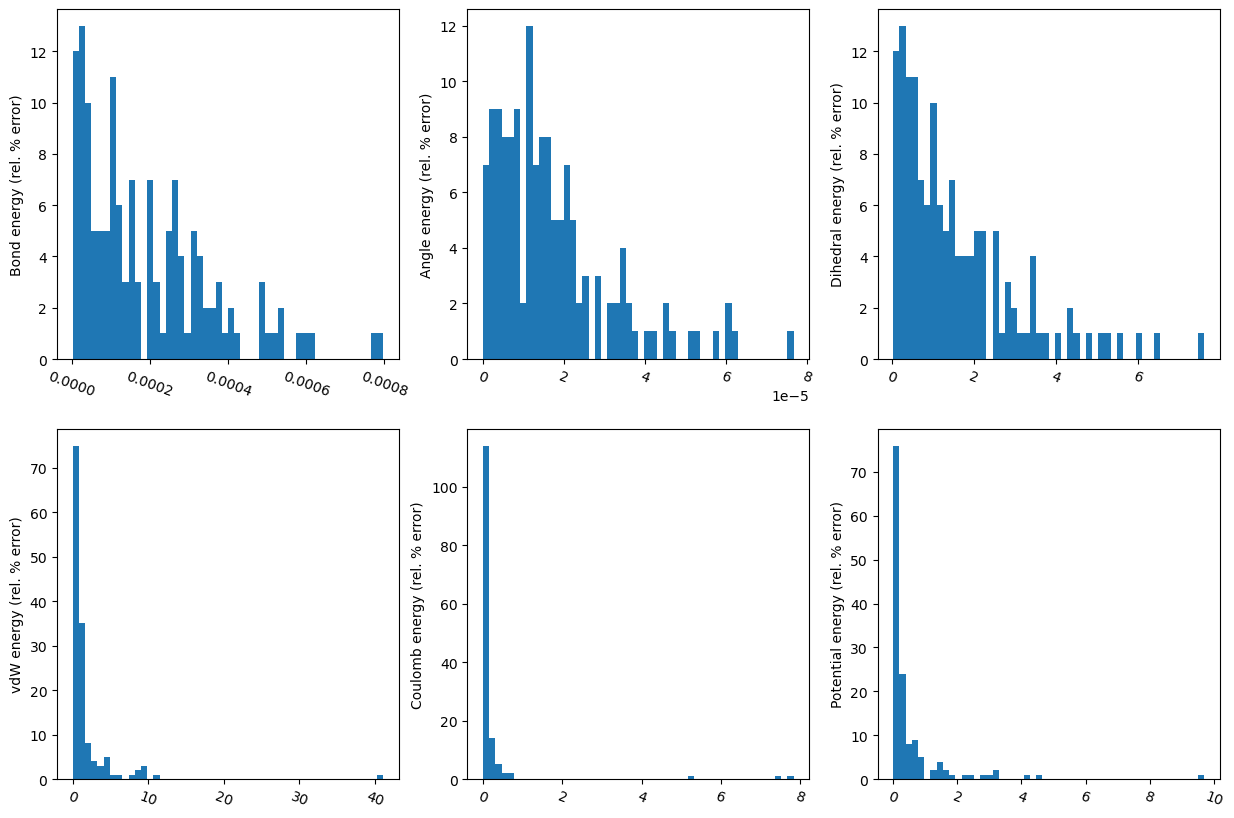

Bond  \
polyester                  poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic ... 0.0001   
                           poly(pentane-1,5-diol-co-heptanedioic acid)        0.0000   
                           poly(butane-1,4-diol-co-nonanedioic acid)          0.0001   
                           poly([4-(hydroxymethyl)cyclohexyl]methanol-co-t... 0.0001   
                           poly(propane-1,3-diol-co-hexanedioic acid)         0.0003   
...                                                                              ...   
polyurethane_nonisocyanate poly(4-[6-[(2-oxo-1,3-dioxolan-4-yl)methoxy]hex... 0.0001   
                           poly(4-[[3-[(2-oxo-1,3-dioxolan-4-yl)methoxy]ph... 0.0001   
                           poly(4-[[4-[(2-oxo-1,3-dioxolan-4-yl)methoxy]ph... 0.0008   
                           poly(4-[6-[(2-oxo-1,3-dioxolan-4-yl)methoxy]hex... 0.0002   
                           poly(4-[[4-[2-[4-[(2-oxo-1,3-dioxolan-4-yl)meth... 0.0000   

                                                                               Angle  \
polyester                  poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic ... 0.0000   
                           poly(pentane-1,5-diol-co-heptanedioic acid)        0.0000   
                           poly(butane-1,4-diol-co-nonanedioic acid)          0.0000   
                           poly([4-(hydroxymethyl)cyclohexyl]methanol-co-t... 0.0000   
                           poly(propane-1,3-diol-co-hexanedioic acid)         0.0000   
...                                                                              ...   
polyurethane_nonisocyanate poly(4-[6-[(2-oxo-1,3-dioxolan-4-yl)methoxy]hex... 0.0000   
                           poly(4-[[3-[(2-oxo-1,3-dioxolan-4-yl)methoxy]ph... 0.0000   
                           poly(4-[[4-[(2-oxo-1,3-dioxolan-4-yl)methoxy]ph... 0.0000   
                           poly(4-[6-[(2-oxo-1,3-dioxolan-4-yl)methoxy]hex... 0.0000   
                           poly(4-[[4-[2-[4-[(2-oxo-1,3-dioxolan-4-yl)meth... 0.0000   

                                                                              Dihedral  \
polyester                  poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic ...   5.9802   
                           poly(pentane-1,5-diol-co-heptanedioic acid)          2.8261   
                           poly(butane-1,4-diol-co-nonanedioic acid)            1.1088   
                           poly([4-(hydroxymethyl)cyclohexyl]methanol-co-t...   1.4836   
                           poly(propane-1,3-diol-co-hexanedioic acid)           1.3097   
...                                                                                ...   
polyurethane_nonisocyanate poly(4-[6-[(2-oxo-1,3-dioxolan-4-yl)methoxy]hex...   1.5674   
                           poly(4-[[3-[(2-oxo-1,3-dioxolan-4-yl)methoxy]ph...   0.1241   
                           poly(4-[[4-[(2-oxo-1,3-dioxolan-4-yl)methoxy]ph...   1.4620   
                           poly(4-[6-[(2-oxo-1,3-dioxolan-4-yl)methoxy]hex...   0.2956   
                           poly(4-[[4-[2-[4-[(2-oxo-1,3-dioxolan-4-yl)meth...   0.2823   

                                                                                  vdW  \
polyester                  poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic ...  0.0266   
                           poly(pentane-1,5-diol-co-heptanedioic acid)         0.0815   
                           poly(butane-1,4-diol-co-nonanedioic acid)          11.2248   
                           poly([4-(hydroxymethyl)cyclohexyl]methanol-co-t...  1.4550   
                           poly(propane-1,3-diol-co-hexanedioic acid)          1.2691   
...                                                                               ...   
polyurethane_nonisocyanate poly(4-[6-[(2-oxo-1,3-dioxolan-4-yl)methoxy]hex...  8.2025   
                           poly(4-[[3-[(2-oxo-1,3-dioxolan-4-yl)methoxy]ph...  1.1399   
                           poly(4-[[4-[(2-oxo-1,3-dioxolan-4-yl)methoxy]ph...  0.223

In [55]:
import matplotlib.pyplot as plt
from polymerist.graphics.plotutils import presize_subplots


col_order = ['Bond', 'Angle', 'Dihedral', 'vdW', 'Coulomb', 'Potential']
max_err_perc : float = None
# max_err_perc : float = 100.0

energy_perc_rel_err = ((edfs_fmt['OpenMM'] - edfs_fmt['LAMMPS']) / edfs_fmt['LAMMPS']).abs() * 100
if max_err_perc:
    err_in_tol = (energy_perc_rel_err.abs() < max_err_perc).all(axis=1)
    energy_perc_rel_err = energy_perc_rel_err[err_in_tol]

fig, ax = presize_subplots(nrows=2, ncols=3)
for col, axis in zip(col_order, ax.flatten()):
    heights, bins, patches = axis.hist(energy_perc_rel_err[col], bins=50)
    axis.set_ylabel(f'{col} energy (rel. % error)')
    axis.tick_params(axis='x', rotation=-20)
    
plt.show()
display(energy_perc_rel_err[col_order])


In [56]:
diff_path = assemble_path(energy_dir, 'Energy_rel_err_table', postfix=f'{MOL_MASTER_DIR.stem}_{lattice_size}', extension='csv')
energy_perc_rel_err.to_csv(diff_path)

energy_fig_path = assemble_path(energy_dir, 'Energy_rel_err_graphs', postfix=f'{MOL_MASTER_DIR.stem}_{lattice_size}', extension='png')
fig.savefig(energy_fig_path)

# Getting just the systems which have density data available

In [ ]:
def get_polymer_name(row : pd.Series) -> str:
    return f'poly({row["IUPAC_name_monomer_0"]}-co-{row["IUPAC_name_monomer_1"]})'.lower()

p = Path('monomer_data_processed/monomer_data_MASTER.csv')
polyid_df = pd.read_csv(p, index_col=0)

polyid_df['polymer_name'] = polyid_df.apply(get_polymer_name, axis=1) # generate column of polymer names from monomer names
polyid_df.set_index(['rxn_name', 'polymer_name'], inplace=True) # reindex by mechanism and molecule name
polyid_df = polyid_df[polyid_df['Density'].notnull()] # filter by density values

common_index = polyid_df.index.intersection(energy_perc_rel_err.index)
polyid_df.loc[common_index]['Density']

In [ ]:
has_density = energy_perc_rel_err.loc[common_index]
has_density['Density'] = polyid_df.loc[common_index]['Density']
has_density